<a href="https://colab.research.google.com/github/SimNaeun/Google_Bootcamp/blob/main/Efficient_Prediction_of_Smoker_Status.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Configuration

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"snaeun","key":"c04c44621f2fcba7568fe3e146ec700d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s3e24

100% 6.81M/6.81M [00:01<00:00, 8.36MB/s]
100% 6.81M/6.81M [00:01<00:00, 5.23MB/s]


In [ ]:
!unzip playground-series-s3e24.zip

Archive:  playground-series-s3e24.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/kaggle.json
/content/playground-series-s3e24.zip
/content/test.csv
/content/sample_submission.csv
/content/train.csv
/content/.config/active_config
/content/.config/default_configs.db
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/gce
/content/.config/configurations/config_default
/content/.config/logs/2023.11.01/13.22.49.087752.log
/content/.config/logs/2023.11.01/13.22.57.692823.log
/content/.config/logs/2023.11.01/13.22.39.200277.log
/content/.config/logs/2023.11.01/13.23.08.659551.log
/content/.config/logs/2023.11.01/13.22.12.591743.log
/content/.config/logs/2023.11.01/13.23.07.863113.log
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv


In [ ]:
from typing import Tuple
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss

import pandas as pd
from sklearn.ensemble import IsolationForest

In [ ]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)

SEED   = 578

# Reading Datasets

In [ ]:
def read_datasets(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    return train_df, test_df

train_path = '/content/train.csv'
test_path = '/content/test.csv'
train_df, test_df = read_datasets(train_path, test_path)

train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

# 'is_original' 원본데이터와 새로 생성된 데이터 구분
train_df['is_original'] = 0
test_df['is_original'] = 0

In [ ]:
!kaggle datasets download -d gauravduttakiit/smoker-status-prediction-using-biosignals

 77% 1.00M/1.30M [00:00<00:00, 1.11MB/s]
100% 1.30M/1.30M [00:00<00:00, 1.36MB/s]


In [ ]:
!unzip smoker-status-prediction-using-biosignals.zip

Archive:  smoker-status-prediction-using-biosignals.zip
  inflating: test_dataset.csv        
  inflating: train_dataset.csv       


In [ ]:
original_path = '/content/train_dataset.csv'
original_df = pd.read_csv(original_path)
original_df['is_original'] = 1
train_df = pd.concat([train_df, original_df])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198240 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  198240 non-null  int64  
 15  hemoglobin        

In [ ]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

# Exploring Loading Information

In [ ]:
#데이터 프레임의 정보 분석

#1.DF 정보, 열 수, 데이터 타입 및 비어 있지 않은 값 수
def analyze_dataframe(df):
    print("DataFrame Information:")
    print("----------------------")
    display(df.info(verbose=True, show_counts=True))
    print("\n")

#DF 상위 3개 행 열별로 출력
    print("DataFrame Values:")
    print("----------------------")
    display(df.head(5).T)
    print("\n")

#각 열의 통계적 특성(평균, 표준편차, 최소값, 최대값...)
    print("DataFrame Description:")
    print("----------------------")
    display(df.describe().T)
    print("\n")

#각 열의 결측값 수
    print("Number of Null Values:")
    print("----------------------")
    display(df.isnull().sum())
    print("\n")

#중복된 행 수
    print("Number of Duplicated Rows:")
    print("--------------------------")
    display(df.duplicated().sum())
    print("\n")

#각 열의 고유한 수
    print("Number of Unique Values:")
    print("------------------------")
    display(df.nunique())
    print("\n")

    print("DataFrame Shape:")
    print("----------------")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

analyze_dataframe(train_df)

DataFrame Information:
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 198240 entries, 0 to 38983
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  198240 non-null  int64  
 1   height(cm)           198240 non-null  int64  
 2   weight(kg)           198240 non-null  int64  
 3   waist(cm)            198240 non-null  float64
 4   eyesight(left)       198240 non-null  float64
 5   eyesight(right)      198240 non-null  float64
 6   hearing(left)        198240 non-null  int64  
 7   hearing(right)       198240 non-null  int64  
 8   systolic             198240 non-null  int64  
 9   relaxation           198240 non-null  int64  
 10  fasting blood sugar  198240 non-null  int64  
 11  Cholesterol          198240 non-null  int64  
 12  triglyceride         198240 non-null  int64  
 13  HDL                  198240 non-null  int64  
 14  LDL                  19

None



DataFrame Values:
----------------------


,0,1,2,3,4
age,55.000,70.000,20.000,35.000,30.000
height(cm),165.000,165.000,170.000,180.000,165.000
weight(kg),60.000,65.000,75.000,95.000,60.000
waist(cm),81.000,89.000,81.000,105.000,80.500
eyesight(left),0.500,0.600,0.400,1.500,1.500
eyesight(right),0.600,0.700,0.500,1.200,1.000
hearing(left),1.000,2.000,1.000,1.000,1.000
hearing(right),1.000,2.000,1.000,1.000,1.000
systolic,135.000,146.000,118.000,131.000,121.000
relaxation,87.000,83.000,75.000,88.000,76.000




DataFrame Description:
----------------------


,count,mean,std,min,25%,50%,75%,max
age,"198,240.000",44.271,11.886,20.000,40.000,40.000,55.000,85.000
height(cm),"198,240.000",165.153,8.896,130.000,160.000,165.000,170.000,190.000
weight(kg),"198,240.000",66.907,12.657,30.000,55.000,65.000,75.000,135.000
waist(cm),"198,240.000",82.817,9.039,51.000,77.000,83.000,89.000,129.000
eyesight(left),"198,240.000",1.008,0.423,0.100,0.800,1.000,1.200,9.900
eyesight(right),"198,240.000",1.003,0.414,0.100,0.800,1.000,1.200,9.900
hearing(left),"198,240.000",1.024,0.154,1.000,1.000,1.000,1.000,2.000
hearing(right),"198,240.000",1.024,0.153,1.000,1.000,1.000,1.000,2.000
systolic,"198,240.000",122.301,12.921,71.000,113.000,121.000,130.000,233.000
relaxation,"198,240.000",76.701,9.136,40.000,70.000,77.000,82.000,146.000




Number of Null Values:
----------------------


age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
is_original            0
dtype: int64



Number of Duplicated Rows:
--------------------------


5517



Number of Unique Values:
------------------------


age                     18
height(cm)              15
weight(kg)              29
waist(cm)              548
eyesight(left)          20
eyesight(right)         18
hearing(left)            2
hearing(right)           2
systolic               128
relaxation              94
fasting blood sugar    259
Cholesterol            279
triglyceride           393
HDL                    123
LDL                    286
hemoglobin             144
Urine protein            6
serum creatinine        34
AST                    196
ALT                    230
Gtp                    444
dental caries            2
smoking                  2
is_original              2
dtype: int64



DataFrame Shape:
----------------
Rows: 198240, Columns: 24


# Feature Engineering

In [ ]:
#BMI, 키와 체중 비율, 키와 나이 비율
def create_features(df):
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    return df

In [ ]:
def massive_feature(df, ignore_list):
    features = [feat for feat in df.columns if feat not in ignore_list]

    for idx1, col_one in enumerate(features):
        for idx2, col_two in enumerate(features):
            if idx1 < idx2:
                df[col_one +'_to_'+ col_two] = df[col_one] / df[col_two]
    return df

In [ ]:
#Isolation Forest를 통해 이상치 식별
def count_outliers(df, features):
    df_subset = df[features]
    clf = IsolationForest(contamination='auto')
    predictions = clf.fit_predict(df_subset)
    outlier_count_df = pd.DataFrame({
        'Outlier_Count': [(pred == -1) for pred in predictions]
    })
    total_outliers = outlier_count_df['Outlier_Count'].sum()
    df['Outlier_Count'] = outlier_count_df
    return df

ignore_list = ['id', 'smoking', 'is_original']
features = [feat for feat in train_df.columns if feat not in ignore_list]
train_df = count_outliers(train_df, features)
test_df = count_outliers(test_df, features)

# Selecting Model Features

In [ ]:
#범주형 피처를 one-hot encoding하여 수치형으로 변환
categorical_features = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
numerical_features = [feat for feat in train_df.columns if feat not in categorical_features and feat not in ['smoking']]

In [ ]:
def one_hot_encode(df, categorical_features):
    return pd.get_dummies(df, columns=categorical_features)

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
#데이터를 클러스터로 그룹화, 각 데이터 포인터와 클러스터 중심 사이의 거리 계산
def kmeans_features(df, features, n_clusters=3):
    X = df[features]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    df['cluster_label'] = kmeans.labels_
    for i, center in enumerate(kmeans.cluster_centers_):
        df[f'dist_to_center_{i}'] = ((X - center) ** 2).sum(axis=1) ** 0.5
    return df

In [ ]:
model_features = [col for col in train_df.columns if col not in ['id',
                                                                 'smoking',
                                                                 #'BMI',
                                                                 #'weight(kg)',
                                                                 #'height(cm)'
                                                                ]]

# Feature Standardization

In [ ]:
#피처 스케일링 -> 다양한 피처가 동일한 스케일로 모델에 영향
def standardize_features(df, features, method='zscore'):
    df_copy = df.copy()
    data_to_scale = df_copy[features]
    if method == 'zscore':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid method. Choose from 'zscore', 'minmax', or 'robust'.")

    standardized_data = scaler.fit_transform(data_to_scale)
    df_copy[features] = standardized_data
    return df_copy

# Training an XGBoost Model

In [ ]:
model_features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries',
 'is_original',
 'Outlier_Count']

# Optuna Hyper-Param Optimization

In [ ]:
#Optuna를 사용해 XGBoost 모델의 하이터파라미터 최적화 자동화
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(train_df[model_features], train_df['smoking'], test_size=0.25, random_state=SEED)
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0, step = 0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step = 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "n_estimators": trial.suggest_int("n_estimators", 256, 4096),
        "eta": trial.suggest_float("eta", 0.01, 0.5, step = 0.01),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "tree_method": "gpu_hist",
    }

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    #Train the XGBoost model with the current hyperparameters
    model = xgb.train(param, xgb.DMatrix(X_train, label = y_train),
                      #num_boost_round=100
                     )
    y_pred = model.predict(xgb.DMatrix(X_test))
    loss = log_loss(y_test, y_pred)

    return loss

def optimize_xgboost_hyperparameters(num_trials=10):
    study = optuna.create_study(direction="minimize")
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(objective, n_trials=num_trials)

    best_params = study.best_params
    return best_params

optimal_params = optimize_xgboost_hyperparameters()
print('.' * 25, '\n')
print(optimal_params)

......................... 

{'booster': 'dart', 'lambda': 5.1036414602315584e-05, 'alpha': 2.1044778121851037e-07, 'subsample': 0.6100000000000001, 'colsample_bytree': 0.7000000000000001, 'max_depth': 4, 'n_estimators': 2612, 'eta': 0.23, 'gamma': 0.2177763517154517, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.6398429696781977e-07, 'skip_drop': 0.5673277941597785}


# XG Boost Model

In [ ]:
#모델 훈련 및 성능 평가

#K-Fold 교차 검증을 사용해 최적의 하이퍼파라미터로 XGBoost 모델 학습하고 평가
def fit_xgboost_with_kfold(df, features, target_variable, parameters, n_splits=10,  random_state=SEED):
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    model = xgb.XGBClassifier(**parameters)

    fold_rocs = []
    fold_loglosses = []
    fold_predictions = []
    fold = 1

#각 폴드에 대해 모델 훈련, ROC-AUC와 로그손실을 계산해 모델 평가(모델이 얼마나 잘 분류하는가)
    for train_index, test_index in kfold.split(X[features], y):
        print(f'Training Fold: {fold} ...')
        X_train, X_test = X[features].iloc[train_index], X[features].iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train,
                  y_train,
                  eval_set = [(X_test, y_test)],
                  verbose = 512,)

#각 폴드에서 학습된 모델로 test data에 대해 예측하고 예측값 평균을 계산해 최종 예측값 반환
        best_iteration = model.get_booster().best_iteration

        y_pred = model.predict(X_test, best_iteration)
        y_pred_proba = model.predict_proba(X_test, best_iteration)[:,1]

        fold_logloss = log_loss(y_test, y_pred_proba)
        fold_roc = roc_auc_score(y_test, y_pred_proba)
        fold_rocs.append(fold_roc)
        fold_loglosses.append(fold_logloss)
        fold += 1

        test_pred = model.predict_proba(test_df[features])[:,1]
        fold_predictions.append(test_pred)

        print('....', '\n')

    predictions = np.mean(fold_predictions, axis=0)

    print("Fold Accuracies:", fold_rocs)
    print("Fold Log Losses:", fold_loglosses)
    print("Mean AUC:", sum(fold_rocs) / len(fold_rocs))
    print("Mean Log Loss:", sum(fold_loglosses) / len(fold_loglosses))

    return model, predictions

In [ ]:
params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.05,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 1.00,
          'gamma'                 : 1.00,
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'gpu_hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }

params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.045,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 0.80,
          'gamma'                 : 0.80,
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'gpu_hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }

#학습된 모델, test data에 대한 예측
xgboost_model, xgboost_predictions = fit_xgboost_with_kfold(train_df,
                                                            model_features,
                                                            target_variable='smoking',
                                                            parameters = params,
                                                            random_state=SEED,
                                                            n_splits = 10)

Training Fold: 1 ...
[0]	validation_0-auc:0.80177
[512]	validation_0-auc:0.87598
[1024]	validation_0-auc:0.87881
[1536]	validation_0-auc:0.87953
[2047]	validation_0-auc:0.87985
.... 

Training Fold: 2 ...
[0]	validation_0-auc:0.79865
[512]	validation_0-auc:0.87226
[1024]	validation_0-auc:0.87519
[1536]	validation_0-auc:0.87651
[2047]	validation_0-auc:0.87700
.... 

Training Fold: 3 ...
[0]	validation_0-auc:0.80917
[512]	validation_0-auc:0.87529
[1024]	validation_0-auc:0.87862
[1536]	validation_0-auc:0.87939
[2047]	validation_0-auc:0.87963
.... 

Training Fold: 4 ...
[0]	validation_0-auc:0.80313
[512]	validation_0-auc:0.87437
[1024]	validation_0-auc:0.87734
[1536]	validation_0-auc:0.87831
[2047]	validation_0-auc:0.87866
.... 

Training Fold: 5 ...
[0]	validation_0-auc:0.80530
[512]	validation_0-auc:0.87557
[1024]	validation_0-auc:0.87852
[1536]	validation_0-auc:0.87967
[2047]	validation_0-auc:0.88019
.... 

Training Fold: 6 ...
[0]	validation_0-auc:0.80069
[512]	validation_0-auc:0.87395

# Prediction

In [ ]:
#흡연 여부를 나타내는 확률 값 포함
#흡연 여부를 예측한 가상 데이터 생성 -> 모델 성능 개선
train_pred = xgboost_model.predict_proba(train_df[model_features])[:,1]
train_df['pred'] = train_pred

#흡연하고 pred이 0.9 초과인 행 중에서 무작위 10개 샘플
train_df[(train_df['smoking'] == 1) & (train_df['pred'] > 0.9)][model_features].sample(10).T

,104192,68705,109512,22117,65219,127737,4214,75608,101431,5601
age,45,40,35,40,45,40,40,45,35,35
height(cm),165,180,165,180,160,175,160,170,170,180
weight(kg),60,85,75,90,60,95,65,60,80,85
waist(cm),79.000,95.000,85.000,95.000,90.000,96.000,86.000,83.000,91.000,90.000
eyesight(left),0.800,0.800,1.000,1.200,0.900,1.500,1.000,0.500,0.800,0.900
eyesight(right),0.700,0.900,1.500,1.000,1.200,2.000,1.000,0.600,0.700,1.000
hearing(left),1,1,1,1,1,1,1,1,1,1
hearing(right),1,1,1,1,1,1,1,1,1,1
systolic,110,122,111,118,150,140,147,148,137,118
relaxation,80,80,77,74,85,100,108,100,84,78


In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['smoking'] = xgboost_predictions

#예측값이 포함된 새로운 csv 파일로 저장
submission.to_csv('xgb_opt_submission.csv', index = False)
submission

,id,smoking
0,159256,0.627
1,159257,0.130
2,159258,0.391
3,159259,0.013
4,159260,0.656
...,...,...
106166,265422,0.662
106167,265423,0.540
106168,265424,0.473
106169,265425,0.078


# XGBoost+Pseudo-Lables
pseudo labeling(의사 라벨링): 사전 학습 모델(xgboost model)로 라벨링이 되지 않은 데이터(sample submission)를 예측하고 그 예측값(xgboost_predictions)을 기준으로 라벨링해서 기존의 학습 데이터(train_df)와 함께 사용하는 방식.(pseudo_train_df)

In [ ]:
test_df['predictions'] = xgboost_predictions
test_df.head()

#확률 값을 기준으로 하는 임계값에 따라 smoking이 1 or 0
#smoking 열 추가하고 predictions 열 삭제
cutoff = 0.95
pseudo_set_1 = test_df[test_df['predictions'] > cutoff]
pseudo_set_1['smoking'] = 1
pseudo_set_1.drop(columns=['predictions'], axis = 1, inplace=True)

pseudo_set_2 = test_df[test_df['predictions'] < 1 - cutoff]
pseudo_set_2['smoking'] = 0
pseudo_set_2.drop(columns=['predictions'], axis = 1, inplace=True)

pseudo_set = pd.concat([pseudo_set_1,pseudo_set_2])
pseudo_set.shape

(27576, 25)

In [ ]:

pseudo_train_df = pd.concat([train_df, pseudo_set])

params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.045,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 0.80,
          'gamma'                 : 0.80,
          'random_state'          : SEED,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'gpu_hist',
          'eval_metric'           : 'auc',
          'early_stopping_rounds' : 256,
          'n_jobs'                : -1,
         }

xgboost_model, xgboost_predictions = fit_xgboost_with_kfold(pseudo_train_df,
                                                            model_features,
                                                            target_variable='smoking',
                                                            parameters = params,
                                                            random_state=SEED,
                                                            n_splits = 10)

Training Fold: 1 ...
[0]	validation_0-auc:0.84053
[512]	validation_0-auc:0.90289
[1024]	validation_0-auc:0.90546
[1536]	validation_0-auc:0.90634
[2047]	validation_0-auc:0.90669
.... 

Training Fold: 2 ...
[0]	validation_0-auc:0.83761
[512]	validation_0-auc:0.89821
[1024]	validation_0-auc:0.90071
[1536]	validation_0-auc:0.90169
[2047]	validation_0-auc:0.90207
.... 

Training Fold: 3 ...
[0]	validation_0-auc:0.83726
[512]	validation_0-auc:0.90009
[1024]	validation_0-auc:0.90279
[1536]	validation_0-auc:0.90380
[2047]	validation_0-auc:0.90420
.... 

Training Fold: 4 ...
[0]	validation_0-auc:0.84022
[512]	validation_0-auc:0.90090
[1024]	validation_0-auc:0.90312
[1536]	validation_0-auc:0.90387
[2047]	validation_0-auc:0.90441
.... 

Training Fold: 5 ...
[0]	validation_0-auc:0.83822
[512]	validation_0-auc:0.89753
[1024]	validation_0-auc:0.90000
[1536]	validation_0-auc:0.90084
[2047]	validation_0-auc:0.90120
.... 

Training Fold: 6 ...
[0]	validation_0-auc:0.83784
[512]	validation_0-auc:0.89772

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['smoking'] = xgboost_predictions
submission.to_csv('xgb_pseudo_opt_submission.csv', index = False)
submission

,id,smoking
0,159256,0.631
1,159257,0.133
2,159258,0.387
3,159259,0.009
4,159260,0.662
...,...,...
106166,265422,0.673
106167,265423,0.538
106168,265424,0.460
106169,265425,0.058


# Linear Classifier

In [ ]:
#로지스틱 회귀 분류 모델 학습 및 예측 수행

#입력 변수와 목표 변수 추출
def train_linear_classifier(train_df, test_df, features):
    X_train = train_df[features]
    y_train = train_df['smoking']

#로지스틱 회귀 모델 생성, 최대 반복 횟수: 500
    model = LogisticRegression(max_iter=500)

#10겹 교차 검증 -> ROU-AUC로 모델 성능 평가
#각 폴드에서 성능 점수와 평균 성능 점수 출력
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')
    print(f'Cross-validation scores: {scores}')
    print(f'Average cross-validation score: {scores.mean()}')

#모델을 학습 데이터에 적합
    model.fit(X_train, y_train)

#예측
    X_test = test_df[features]
    test_predictions = model.predict_proba(X_test)[:,1]

    return model, test_predictions

# Blended Model

In [ ]:
#다양한 분류 모델을 사용해 블렌딩된 예측 생성
def blended_predictions(train, test, features):
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "hist_gbm" : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80),
        "CatBoost": CatBoostClassifier(silent=True),
        "LGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier()
    }

    test_preds = []

#각 분류 모델에 대해 10겹 교차 검증&예측
    for name, clf in classifiers.items():
        cross_val_pred = cross_val_predict(clf, train[features], train['smoking'], cv=10, method='predict_proba')[:, 1]

        clf.fit(train[features], train['smoking'])

        test_pred = clf.predict_proba(test[features])[:, 1]
        test_preds.append(test_pred)

        print(f"{name} done!")

 #각 모델에서 생성된 test 예측값을 평균내어 블렌딩된 예측값 반환
    blended_pred = np.mean(test_preds, axis=0)
    return blended_pred




# ML Explainability
어떤 피처가 예측에 가장 중요한 역할을 하는지 시각적으로 파악

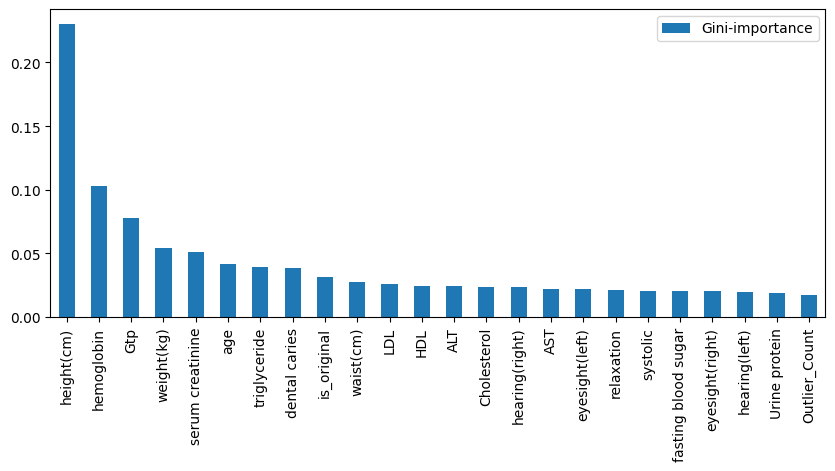

In [ ]:
import matplotlib.pyplot as plt

#feat에 각 피처(key)와 해당 피처의 중요도(value) 저장
feats = {}
for feature, importance in zip(train_df[model_features].columns, xgboost_model.feature_importances_):
    feats[feature] = importance

#df를 중요도에 따라 내림차순 정렬, 각 피처의 중요도를 수평 막대 그래프로 시각화
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=90, figsize=(10,4))
plt.show()